Test Jacobi-iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair

import matplotlib.pyplot as plt
import math
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet


In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
n_test = 2**6
test_set = MechanicalDataSet('data/data_Ti64/thermal_Ti64.h5', device)
# n_test = 2**5
# test_set = ThermalDataSet('data/thermal/thermal_test.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
mask_test, dirich_idx_test, dirich_value_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_test, t_conn_test, m_test, msk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(mask_test[k], 0).to(device_predict))

In [4]:
t_conn_test.shape

torch.Size([1, 1, 65, 65])

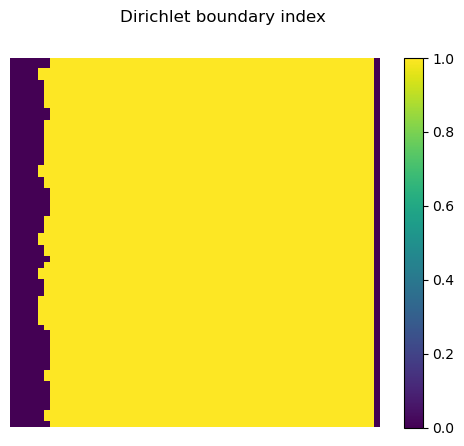

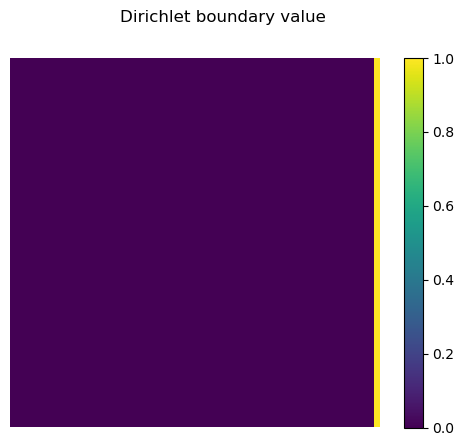

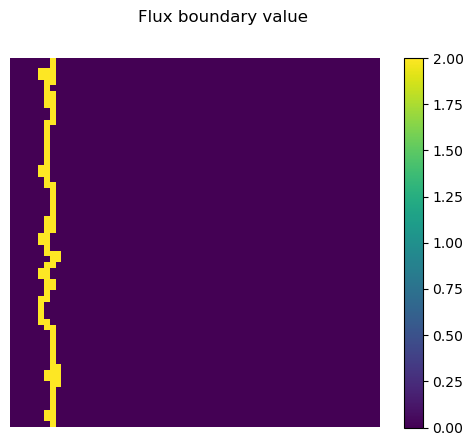

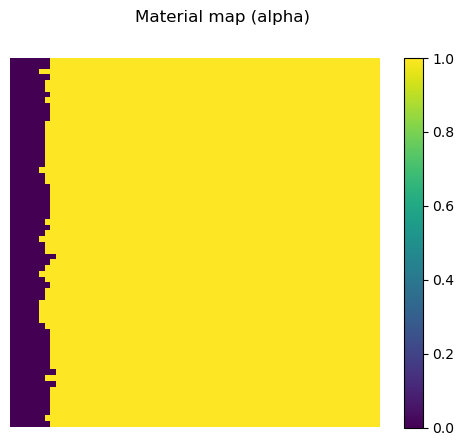

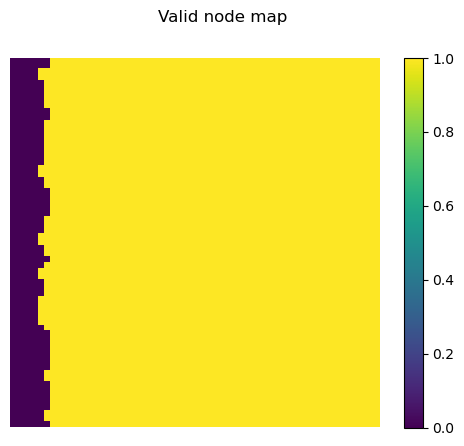

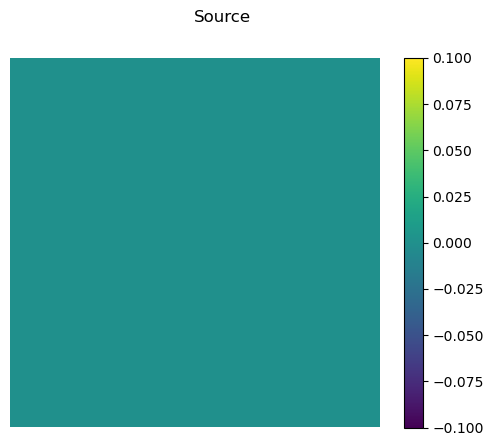

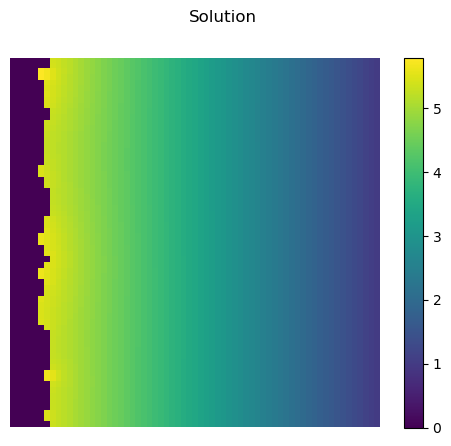

In [5]:
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

In [6]:
n_elem = n_test
ku, kf = 1, 1
h = 0.0061*4
grid = SingleGrid(h, n_elem=n_elem, mode='thermal', dev=device_predict)

In [7]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(False):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, msk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "Benchmark")
    plot.plot_thermalfield(solution_test[0], "Test")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

## Test multigrid performance

In [8]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,msk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test,msk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 0.48677846178158324
1 0.5917969456861776
2 0.5480388577412605
3 0.5079689019180879
4 0.4672662767046368
5 0.4292619529195034
6 0.39403372651638974
7 0.36153562490872565
8 0.3316111562409451
9 0.304087594976109
10 0.27879169113224295
11 0.25555652083449076
12 0.23422388424143237
13 0.2146452306956366
14 0.196681874686407
15 0.18020484784916166
16 0.16509455302254156
17 0.1512403130606285
18 0.13853986865225934
19 0.12689885757766273
20 0.11623029483680879
21 0.10645406521743225
22 0.09749643506886896
23 0.08928958709169797
24 0.08177118011266289
25 0.07488393465151005
26 0.06857524433895078
27 0.06279681275844569
28 0.05750431496455197
29 0.05265708272223379
30 0.04821781237885772
31 0.04415229420203055
32 0.04042916197716473
33 0.03701966164791065
34 0.033897437793564834
35 0.031038336763895107
36 0.028420225330179603
37 0.026022823756965213
38 0.023827552250777886
39 0.021817389796555776
40 0.01997674444908608
41 0.018291334203486387
42 0.016748077624858658
43 0.015334993472105821
4

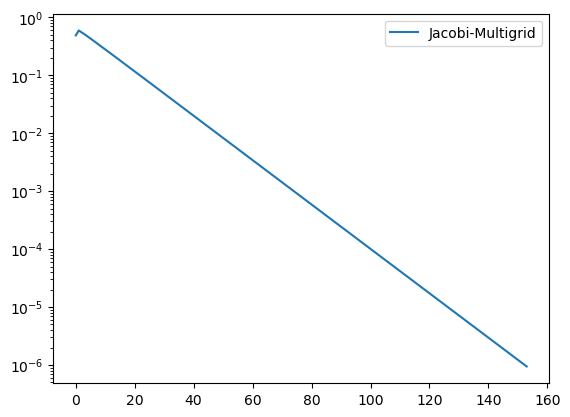

In [9]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

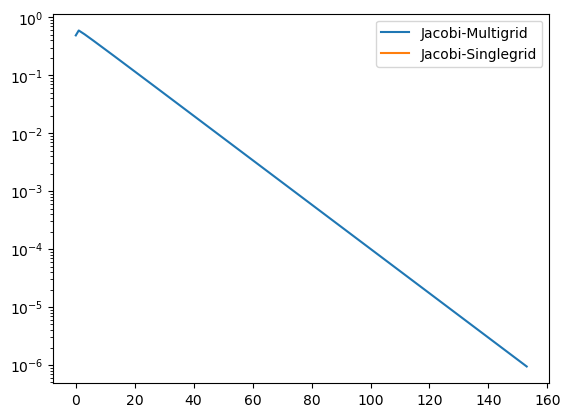

In [10]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr, label='Jacobi-Singlegrid')
plt.yscale('log')
plt.legend()
plt.show()

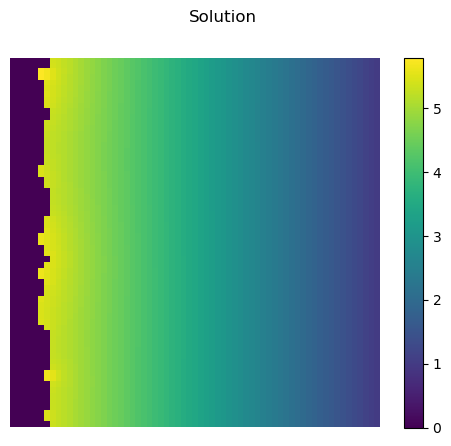

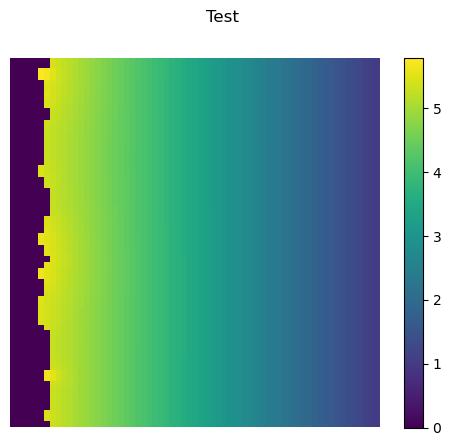

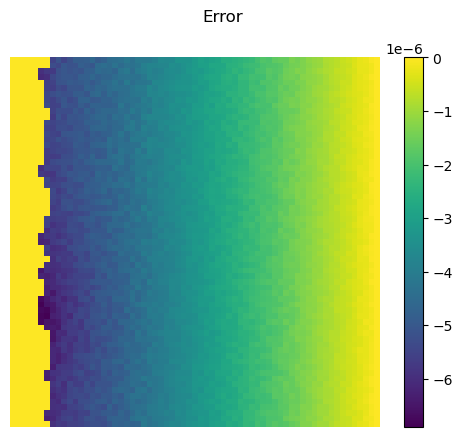

In [11]:
plot.plot_thermalfield(solution_test[0], "Solution")
plot.plot_thermalfield(u_mg_jac[0], "Test")
plot.plot_thermalfield(u_mg_jac[0]-solution_test[0], "Error")

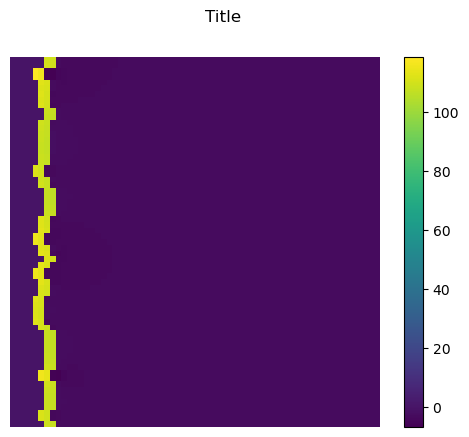

In [14]:
from feanet.derivative import DerivativeNet
x_derivative = DerivativeNet(1, h)
flux=x_derivative(u_mg_jac.float(), mask_test, 'x')
plot.plot_thermalfield(flux[0])